# SkyWeather Forecast Metrics

## Load libraries and packages

In [146]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Set parameters and flags

In [147]:
# set whether to normalize data range across datasets to 0-1
normalize_datapoints = True

# set whether to use pressure as comparator for all parameters
compare_pressure_only = True

# set number of forecast datapoints, eg 8 = 1am, 2am, 3am, ..., 8am
forecast_datapoints = 2

# set moving average setting for all plots and pressure reading
data_moving_average = 3

# set the altitude in metres of groundtruth weather station
groundtruth_altitude = 49.0

# set which data source to plot
show_ibm = True ; show_darksky = True; show_sengkang = True;

## Define WeatherData class

In [148]:
class WeatherData:
    def __init__(self, data_s, data_i, data_d, min_timestamp, max_timestamp):
        """
        Class to store datasets for weather forecast

        Args:
            data_s: Ground truth (pandas dataframe)
            data_i: Forecast 1 (pandas dataframe)
            data_d: Forecast 2 (pandas dataframe)
            min_timestamp: Start Linux time (Integer) 
            max_timestamp: End Linux time (Integer)

        Returns:
            object with above properties
        """

        self.data_s = data_s; self.data_i = data_i; self.data_d = data_d
        self.min_timestamp = min_timestamp; self.max_timestamp = max_timestamp

## Define error metrics

In [149]:
class ErrorMetrics:
    def __init__(self, groundtruth_s = [], forecast_w = [], forecast_i = [], forecast_d = [], w_mae=0, i_mae=0, d_mae=0, w_mae_delta_pct=0, w_mse=0, i_mse=0, d_mse=0, w_mse_delta_pct=0):
        """
        Class to store error metrics for weather forecast

        Args:
            groundtruth_s: Ground truth (pandas dataframe)
            forecast_w: Winning forecast (pandas dataframe)
            forecast_i: Forecast 1 (pandas dataframe)
            forecast_d: Forecast 2 (pandas dataframe)
            w_mae: Winning forecast MAE mean absolute error (Float)
            i_mae: Forecast 1 MAE mean absolute error (Float)
            d_mae: Forecast 2 MAE mean absolute error (Float)
            w_mae_delta_pct: Winning forecast MAE delta % (Float)
            w_mse: Winning forecast MSE mean squared error (Float)
            i_mse: Forecast 1 MSE mean squared error (Float)
            d_mse: Forecast 2 MSE mean squared error (Float)
            w_mse_delta_pct: Winning forecast MSE delta % (Float)

        Returns:
            object with above properties
        """
        
        self.groundtruth_s = groundtruth_s; self.forecast_w = forecast_w; self.forecast_i = forecast_i; self.forecast_d = forecast_d
        self.w_mae = w_mae; self.i_mae = i_mae; self.d_mae = d_mae; self.w_mae_delta_pct = w_mae_delta_pct
        self.w_mse = w_mse; self.i_mse = i_mse; self.d_mse = d_mse; self.w_mse_delta_pct = w_mse_delta_pct

    def print(self):
        """
        Method to print error metrics
        
        Args:
            None
        
        Returns:
            None
        """
        
        print('===================================')
        print('[Overall Winner MAE]', self.w_mae)
        print('[Overall IBM Data MAE]', self.i_mae)
        print('[Overall Dark Sky MAE]', self.d_mae)
        print('[Overall Winner delta %]', self.w_mae_delta_pct)

        print('\n[Overall Winner MSE]', self.w_mse)
        print('[Overall IBM Data MSE]', self.i_mse)
        print('[Overall Dark Sky MSE]', self.d_mse)
        print('[Overall Winner delta %]', self.w_mse_delta_pct)
        print('===================================')

## Load and prepare data sets

In [150]:
def load_and_prep_data(groundtruth_csv, i_csv, d_csv):
    """
    Function to load and prepare datasets for forecast

    Args:
        groundtruth_csv: Ground truth csv filename (String)
        i_csv: Forecast 1 csv filename (String)
        d_csv: Forecast 2 csv filename (String)

    Returns:
        WeatherData object
    """
        
    data_s = pd.read_csv(groundtruth_csv) # extracted sengkang bloomsky data
    # timestamp,country,city,latitude,longitude,temperature,pressure,humidity,wind,direction,last24h,rate,uv
    
    data_i = pd.read_csv(i_csv) # extracted ibm forecast data
    # timestamp,temperature,humidity,wind_speed,wind_direction,rain_probability, pressure

    data_d = pd.read_csv(d_csv) # extracted darksky forecast data
    # timestamp,temperature,humidity,wind_speed,wind_direction,rainfall,precipProbability,summary,icon,apparentTemperature,dewPoint,pressure,pressureError,cloudCover,uvIndex,visibility

    # convert groundtruth pressure reading to float datatype
    data_s['pressure'] = data_s['pressure'].astype(float)
    
    # adjust forecast sea level pressure readings to station pressure reading
    data_i['pressure'] -= (groundtruth_altitude/9.2)
    data_d['pressure'] -= (groundtruth_altitude/9.2)
    
    # apply moving average on pressure readings for more robust comparison
    data_s['pressure'] = data_s['pressure'].rolling(window=data_moving_average).mean()
    data_i['pressure'] = data_i['pressure'].rolling(window=data_moving_average).mean()
    data_d['pressure'] = data_d['pressure'].rolling(window=data_moving_average).mean()
         
    # declare for use in the dependent block below
    def round_timestamp(value, multiple):
        return int(multiple * round(float(value)/multiple))

    # convert sengkang local timestamp to UTC timestamp
    data_s['timestamp'] = data_s['timestamp'] - 28800

    # align sengkang timestamp values for comparison, ibm and dark sky data seems aligned
    for n in range(len(data_s['timestamp'])):
        data_s.loc[n,'timestamp'] = round_timestamp(data_s.loc[n,'timestamp'],1800)

    # drop readings belonging to 30-min mark, because ibm and darksky data is at hourly mark
    data_s = data_s[data_s.timestamp % 3600 == 0]

    # define range that is common across all datasets (sengkang, ibm, darksky etc)
    min_timestamp = max(min(data_s['timestamp']),min(data_i['timestamp']),min(data_d['timestamp']))
    max_timestamp = min(max(data_s['timestamp']),max(data_i['timestamp']),max(data_d['timestamp']))

    # drop readings outside of the range that is common for the 3 sets of input data
    data_s = data_s[data_s.timestamp >= min_timestamp]; data_s = data_s[data_s.timestamp <= max_timestamp]
    data_i = data_i[data_i.timestamp >= min_timestamp]; data_i = data_i[data_i.timestamp <= max_timestamp]
    data_d = data_d[data_d.timestamp >= min_timestamp]; data_d = data_d[data_d.timestamp <= max_timestamp]

    return WeatherData(data_s, data_i, data_d, min_timestamp, max_timestamp)

## Create plot method

In [151]:
def plot_reading(parameter, weather_data):
    """
    Method to plot weather reading

    Args:
        parameter: weather reading to plot (String)
        weather_data: weather datasets (WeatherData)

    Returns:
        None
    """
    
    # retrieve datasets and range from WeatherData object
    data_s = weather_data.data_s; data_i = weather_data.data_i; data_d = weather_data.data_d
    min_timestamp = weather_data.min_timestamp; max_timestamp = weather_data.max_timestamp
    
    figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')    
    if show_ibm: plt.plot(data_i['timestamp'],data_i[parameter].rolling(window=data_moving_average).mean(),label='IBM Data')
    if show_darksky: plt.plot(data_d['timestamp'],data_d[parameter].rolling(window=data_moving_average).mean(),label='Dark Sky')
    if show_sengkang: plt.plot(data_s['timestamp'],data_s[parameter].rolling(window=data_moving_average).mean(),label='Sengkang')
    
    if parameter == 'temperature': plot_title = 'temperature (°C)'
    elif parameter == 'pressure': plot_title = 'pressure (Bar)'
    elif parameter == 'humidity': plot_title = 'humidity (%)'
    
    plt.title('\nDaily hourly forecast of ' + plot_title + ' vs Sengkang bloomsky station actual reading\n')    
    plt.xlim(min_timestamp, max_timestamp);
    plt.legend(); plt.show();

## Create error metrics method

In [152]:
def generate_error_metrics(parameter, weather_data):
    """
    Method to generate error metrics

    Args:
        parameter: weather reading to forecast (String)
        weather_data: weather datasets (WeatherData)

    Returns:
        object with error metrics (ErrorMetrics)
    """
    
    # retrieve datasets and range from WeatherData object
    data_s = weather_data.data_s; data_i = weather_data.data_i; data_d = weather_data.data_d
    min_timestamp = weather_data.min_timestamp; max_timestamp = weather_data.max_timestamp

    error_encountered = False; error_message_buffer = ''
    groundtruth_s = [] # bloomsky sengkang station data
    forecast_w = []; forecast_w_mae = []; forecast_w_mse = []
    forecast_i = []; forecast_i_mae = []; forecast_i_mse = []
    forecast_d = []; forecast_d_mae = []; forecast_d_mse = []

    row_header = []
    for f in range(forecast_datapoints):
        row_header.append(parameter + str(f+1))

    for t in range(min_timestamp,max_timestamp+86400,86400):
        try:
            
            # generate row for forecast tables
            row_s = []; row_i = []; row_d = []
            for f in range(forecast_datapoints):
                row_s.append(data_s[data_s.timestamp == (t + (f+1)*3600)].iloc[0][parameter])
                row_i.append(data_i[data_i.timestamp == (t + (f+1)*3600)].iloc[0][parameter])
                row_d.append(data_d[data_d.timestamp == (t + (f+1)*3600)].iloc[0][parameter])

            # use pressure reading to pick winner (phone sensor limitation)
            if compare_pressure_only:
                temp_parameter = parameter; parameter = 'pressure'

            current_s = data_s[data_s.timestamp == t].iloc[0][parameter]
            current_i = data_i[data_i.timestamp == t].iloc[0][parameter]
            current_d = data_d[data_d.timestamp == t].iloc[0][parameter]

            # use pressure reading to pick winner (phone sensor limitation)
            if compare_pressure_only:
                parameter = temp_parameter
            
            # default algo to pick winner from most accurate current reading
            # if abs(current_i - current_s) < abs(current_d - current_s):

            # alternative algo to use weights and MSE instead of MAE to pick winner
            # if 0.473221 * (current_i - current_s) ** 2 < 0.52677 * (current_d - current_s) ** 2:

            # alternative algo to use MSE instead of MAE to pick winner (no weights)
            if (current_i - current_s) ** 2 < (current_d - current_s) ** 2:
                row_w = row_i # w for winner
            else:
                row_w = row_d # w for winner

            # append forecast rows to table
            groundtruth_s.append(row_s)
            forecast_w.append(row_w)
            forecast_i.append(row_i)
            forecast_d.append(row_d)
            
        except Exception as e:
            if not error_encountered: error_message_buffer = '* missing timestamp(s) - '
            error_message_buffer += str(t) + ' '        
        
    # convert forecast tables to dataframes
    groundtruth_s = pd.DataFrame(groundtruth_s, columns = row_header)
    forecast_w = pd.DataFrame(forecast_w, columns = row_header)
    forecast_i = pd.DataFrame(forecast_i, columns = row_header)
    forecast_d = pd.DataFrame(forecast_d, columns = row_header)

    # find range - calculation by considering all values in entire dataset
    min_reading = min(min(groundtruth_s.min()),min(forecast_w.min()),min(forecast_i.min()),min(forecast_d.min()))
    max_reading = max(max(groundtruth_s.max()),max(forecast_w.max()),max(forecast_i.max()),max(forecast_d.max()))

    if normalize_datapoints:
        # normalise input data values using minmax scaler, formula here - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
        for reading in range(len(groundtruth_s)):
            # find range - below is old calculation factoring only the range of the current forecast dataset
            # min_reading = min(groundtruth_s.min(axis=1)[reading],forecast_w.min(axis=1)[reading],forecast_i.min(axis=1)[reading],forecast_d.min(axis=1)[reading])
            # max_reading = max(groundtruth_s.max(axis=1)[reading],forecast_w.max(axis=1)[reading],forecast_i.max(axis=1)[reading],forecast_d.max(axis=1)[reading])

            groundtruth_s.iloc[reading] = (groundtruth_s.iloc[reading] - min_reading) / (max_reading - min_reading)
            forecast_w.iloc[reading] = (forecast_w.iloc[reading] - min_reading) / (max_reading - min_reading)
            forecast_i.iloc[reading] = (forecast_i.iloc[reading] - min_reading) / (max_reading - min_reading)
            forecast_d.iloc[reading] = (forecast_d.iloc[reading] - min_reading) / (max_reading - min_reading)

    # calculate and generate error tables
    forecast_w_mae = abs(forecast_w - groundtruth_s)
    forecast_i_mae = abs(forecast_i - groundtruth_s)
    forecast_d_mae = abs(forecast_d - groundtruth_s)
    forecast_w_mse = (forecast_w - groundtruth_s) ** 2
    forecast_i_mse = (forecast_i - groundtruth_s) ** 2
    forecast_d_mse = (forecast_d - groundtruth_s) ** 2

    # calculate the average error values
    forecast_w_mae['mae'] = forecast_w_mae.sum(axis=1) / len(forecast_w_mae.columns)
    forecast_i_mae['mae'] = forecast_i_mae.sum(axis=1) / len(forecast_i_mae.columns)
    forecast_d_mae['mae'] = forecast_d_mae.sum(axis=1) / len(forecast_d_mae.columns)
    forecast_w_mse['mse'] = forecast_w_mse.sum(axis=1) / len(forecast_w_mse.columns)
    forecast_i_mse['mse'] = forecast_i_mse.sum(axis=1) / len(forecast_i_mse.columns)
    forecast_d_mse['mse'] = forecast_d_mse.sum(axis=1) / len(forecast_d_mse.columns)
    
    # calculate final average error values
    forecast_w_mae = round(forecast_w_mae['mae'].sum(axis=0) / len(forecast_w_mae),7)
    forecast_i_mae = round(forecast_i_mae['mae'].sum(axis=0) / len(forecast_i_mae),7)
    forecast_d_mae = round(forecast_d_mae['mae'].sum(axis=0) / len(forecast_d_mae),7)
    forecast_w_mse = round(forecast_w_mse['mse'].sum(axis=0) / len(forecast_w_mse),7)
    forecast_i_mse = round(forecast_i_mse['mse'].sum(axis=0) / len(forecast_i_mse),7)
    forecast_d_mse = round(forecast_d_mse['mse'].sum(axis=0) / len(forecast_d_mse),7)
    
    # calculate % delta of winner algorithm
    w_mae_delta = round(100 * max((forecast_w_mae - forecast_i_mae)/forecast_i_mae,(forecast_w_mae - forecast_d_mae)/forecast_d_mae),7)
    w_mse_delta = round(100 * max((forecast_w_mse - forecast_i_mse)/forecast_i_mse,(forecast_w_mse - forecast_d_mse)/forecast_d_mse),7)

    plot_reading(parameter, weather_data)
    
    print(error_message_buffer + '\n')
    print('[Winner MAE]', forecast_w_mae)
    print('[IBM Data MAE]', forecast_i_mae)
    print('[Dark Sky MAE]', forecast_d_mae)
    print('[Winner delta %]', w_mae_delta)
    
    print('\n[Winner MSE]', forecast_w_mse)
    print('[IBM Data MSE]', forecast_i_mse)
    print('[Dark Sky MSE]', forecast_d_mse)
    print('[Winner delta %]', w_mse_delta)
    print()
    
    return ErrorMetrics(groundtruth_s, forecast_w, forecast_i, forecast_d, forecast_w_mae, forecast_i_mae, forecast_d_mae, w_mae_delta, forecast_w_mse, forecast_i_mse, forecast_d_mse, w_mse_delta)


## Create combine error metrics

In [153]:
def combine_error_metrics(*args):
    """
    Method to combine 2 or more error metrics

    Args:
        object(s) containing error metrics (ErrorMetrics)

    Returns:
        object with error metrics (ErrorMetrics)
    """

    overall_error = ErrorMetrics()

    for error_metrics in args:
        overall_error.w_mae += error_metrics.w_mae
        overall_error.i_mae += error_metrics.i_mae
        overall_error.d_mae += error_metrics.d_mae
        overall_error.w_mae_delta_pct += error_metrics.w_mae_delta_pct
        overall_error.w_mse += error_metrics.w_mse
        overall_error.i_mse += error_metrics.i_mse
        overall_error.d_mse += error_metrics.d_mse
        overall_error.w_mse_delta_pct += error_metrics.w_mse_delta_pct
        
    overall_error.w_mae /= len(args); overall_error.w_mae = round(overall_error.w_mae,7)
    overall_error.i_mae /= len(args); overall_error.i_mae = round(overall_error.i_mae,7)
    overall_error.d_mae /= len(args); overall_error.d_mae = round(overall_error.d_mae,7)
    overall_error.w_mae_delta_pct /= len(args); overall_error.w_mae_delta_pct = round(overall_error.w_mae_delta_pct,7)
    overall_error.w_mse /= len(args); overall_error.w_mse = round(overall_error.w_mse,7)
    overall_error.i_mse /= len(args); overall_error.i_mse = round(overall_error.i_mse,7)
    overall_error.d_mse /= len(args); overall_error.d_mse = round(overall_error.d_mse,7)
    overall_error.w_mse_delta_pct /= len(args); overall_error.w_mse_delta_pct = round(overall_error.w_mse_delta_pct,7)
    
    overall_error.print()
    return overall_error

## Load data sets

In [154]:
# load and prep data
weather_data = load_and_prep_data('sengkang.csv', 'ibm_forecast.csv', 'darksky_forecast.csv')

# optional - limit range of weather readings
#weather_data.min_timestamp = 1545000000; weather_data.max_timestamp = 1545150000


## Generate error metrics

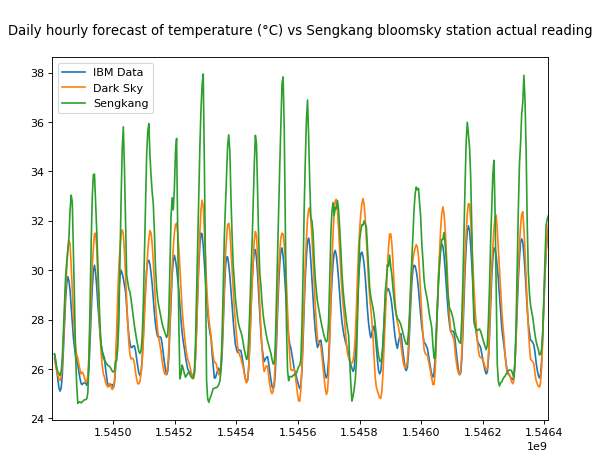

* missing timestamp(s) - 1546444800 

[Winner MAE] 0.1639628
[IBM Data MAE] 0.1462539
[Dark Sky MAE] 0.2450774
[Winner delta %] 12.1083267

[Winner MSE] 0.0401346
[IBM Data MSE] 0.0316699
[Dark Sky MSE] 0.0790346
[Winner delta %] 26.7279025



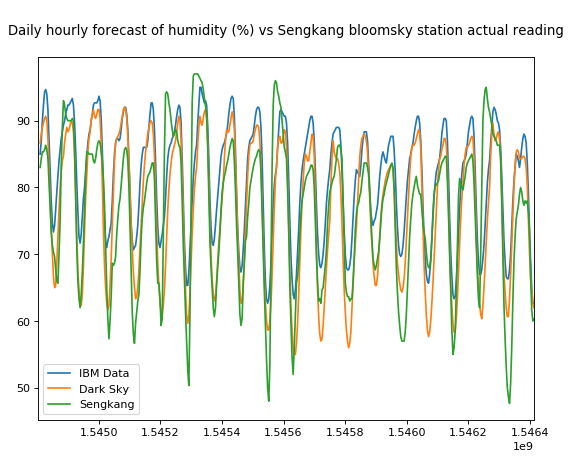

* missing timestamp(s) - 1546444800 

[Winner MAE] 0.2207602
[IBM Data MAE] 0.2280702
[Dark Sky MAE] 0.2383041
[Winner delta %] -3.2051535

[Winner MSE] 0.0670078
[IBM Data MSE] 0.0717999
[Dark Sky MSE] 0.0759422
[Winner delta %] -6.6742433



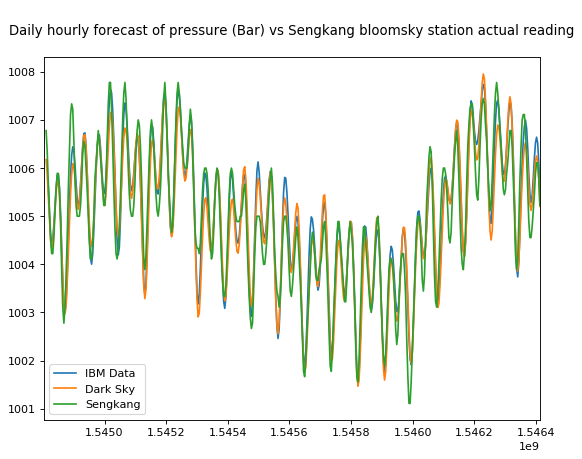

* missing timestamp(s) - 1546444800 

[Winner MAE] 0.0682859
[IBM Data MAE] 0.0675889
[Dark Sky MAE] 0.085742
[Winner delta %] 1.0312344

[Winner MSE] 0.0076832
[IBM Data MSE] 0.0086328
[Dark Sky MSE] 0.0116321
[Winner delta %] -10.9999073



In [155]:
# generate error metrics
temperature_error = generate_error_metrics('temperature', weather_data)
humidity_error = generate_error_metrics('humidity', weather_data)
pressure_error = generate_error_metrics('pressure', weather_data)

## Show overall metrics

In [156]:
overall_error = combine_error_metrics(temperature_error, humidity_error)


[Overall Winner MAE] 0.1923615
[Overall IBM Data MAE] 0.187162
[Overall Dark Sky MAE] 0.2416908
[Overall Winner delta %] 4.4515866

[Overall Winner MSE] 0.0535712
[Overall IBM Data MSE] 0.0517349
[Overall Dark Sky MSE] 0.0774884
[Overall Winner delta %] 10.0268296
